Imports!

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Activation

Get training and test data.

In [55]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)

Define a function to strip away useless columns in our dataset.

In [56]:
def drop_useless_cols(df):
    useful = ['Survived', 'Pclass', 'Sex', 'Age', 'Fare']
    for col in list(df):
        if col not in useful:
            df = df.drop(col, axis=1)
    return df

What good's a function if you never use it?

In [57]:
train = drop_useless_cols(train)
test = drop_useless_cols(test)

Always good to scope out null values so they don't blindside you down the road.

In [58]:
print(train.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
Fare          0
dtype: int64


Let's explore the data with the aim of writing a function that cleans up those null Age values in a reasonable way.

In [59]:
s = train.groupby(['Sex', 'Pclass'])[['Age']].apply(np.nanmedian)

Let's denullify the age column.

In [60]:
med_age_upperclass_woman = s[0]
med_age_middleclass_woman = s[1]
med_age_lowerclass_woman = s[2]
med_age_upperclass_man = s[3]
med_age_middleclass_man = s[4]
med_age_lowerclass_man = s[5]

def denullify_age_col(df):
    df_ucw = df[(df['Sex'] == 'female') & (df['Pclass'] == 1)].fillna(med_age_upperclass_woman)
    df_mcw = df[(df['Sex'] == 'female') & (df['Pclass'] == 2)].fillna(med_age_middleclass_woman)
    df_lcw = df[(df['Sex'] == 'female') & (df['Pclass'] == 3)].fillna(med_age_lowerclass_woman)
    df_ucm = df[(df['Sex'] == 'male') & (df['Pclass'] == 1)].fillna(med_age_upperclass_man)
    df_mcm = df[(df['Sex'] == 'male') & (df['Pclass'] == 2)].fillna(med_age_middleclass_man)
    df_lcm = df[(df['Sex'] == 'male') & (df['Pclass'] == 3)].fillna(med_age_lowerclass_man)
    df = pd.concat([df_ucw, df_mcw, df_lcw, df_ucm, df_mcm, df_lcm], axis=0)
    return df

train = denullify_age_col(train)
test = denullify_age_col(test)

Apparently we need to get_dummies to deal with some of our datatype issues (methinks, anyway...)

In [61]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

Now all we've got between us and building our models is the fact that Pclass is currently a quantitative column when it should be categorical.

In [62]:
def categorize_pclass(df):
    df = pd.concat([df, pd.get_dummies(df['Pclass'], prefix='Pclass_')], axis=1).drop('Pclass', axis=1)
    return df

train = categorize_pclass(train)
test = categorize_pclass(test)

Final data input preparations.

In [63]:
y = pd.get_dummies(train['Survived'])

In [64]:
X = train.drop('Survived', axis=1)

Let's test some conventional machine learning models on this data and see what kind of accuracy we can get.

In [65]:
# Make sure our data is shaped right for sklearn
X_vals = X.values # just the features columns
y_vals = y.values[:,1] # just the "Survived" column

In [66]:
from sklearn.metrics import accuracy_score

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()
clf_nb.fit(X_vals, y_vals)
pred_nb = clf_nb.predict(X_vals)
acc_nb = accuracy_score(y_vals, pred_nb)
print("Naive Bayes training accuracy: {0}%".format(acc_nb*100.))

# Support Vector Machines
from sklearn.svm import SVC
clf_svm = SVC()
clf_svm.fit(X_vals, y_vals)
pred_svm = clf_svm.predict(X_vals)
acc_svm = accuracy_score(y_vals, pred_svm)
print("SVM training accuracy: {0}%".format(acc_svm*100.))

# AdaBoosted Decision Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
clf_ada_dtc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                 n_estimators=50,
                                 learning_rate=1.,
                                 algorithm='SAMME.R')
clf_ada_dtc.fit(X_vals, y_vals)
pred_ada_dtc = clf_ada_dtc.predict(X_vals)
acc_ada_dtc = accuracy_score(y_vals, pred_ada_dtc)
print("AdaBoosted DecisionTree accuracy: {0}%".format(acc_ada_dtc*100.))

Naive Bayes training accuracy: 77.77777777777779%
SVM training accuracy: 89.00112233445566%
AdaBoosted DecisionTree accuracy: 97.75533108866442%


Time for the neural net models.

In [67]:
model = Sequential()
model.add(Dense(units=200, input_shape=X_vals.shape[1:]))
model.add(Activation('relu'))
model.add(Dense(units=200))
model.add(Activation('relu'))
model.add(Dense(units=24))
model.add(Activation('relu'))
model.add(Dense(units=2))
model.add(Activation('softmax'))

optim = SGD(lr=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [68]:
history = model.fit(X_vals, y.values, validation_split=0.33, epochs=1000, batch_size=16, verbose=0)

print("\n\nKeras neural net accuracy: {0}%".format(model.evaluate(X_vals, y.values)[1]*100.))
model.evaluate(X_vals, y.values)

 32/891 [>.............................] - ETA: 0s

Keras neural net accuracy: 81.70594839268395%
 32/891 [>.............................] - ETA: 0s

[0.41467290715336397, 0.81705948392683947]

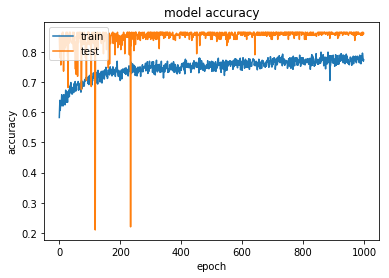

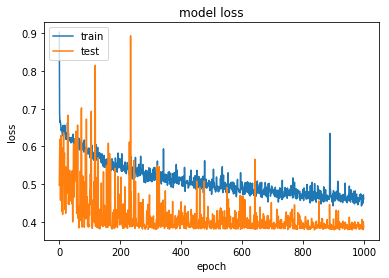

In [69]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
p_sub = model.predict_classes(test.values)

predictions = pd.DataFrame()
predictions['PassengerId'] = test.index
predictions['Survived'] = p_sub

 32/418 [=>............................] - ETA: 0s

Make sure our predictions dataframe has the right dimensions (that's 418x2)

In [71]:
predictions.shape

(418, 2)

Save predictions to a local csv file.

In [72]:
predictions.to_csv('predictions.csv', index=False)